MODEL SELECTION AND EVALUATION: Part 1

In [1]:
import os
import numpy as np
from PIL import Image
from fastai.data.transforms import get_image_files
import fastai.data.transforms as fdt
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.data.block import DataBlock
from fastai.vision.core import PILImage
from fastai.vision.data import ImageBlock, CategoryBlock
from fastai.vision.augment import Resize
from fastai.vision.learner import vision_learner
from torchvision.models.resnet import resnet18
from torchvision import models
from fastai.metrics import error_rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import src.constants as cn
import src.util as util

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Lecture 3: Statistical Methods (Nicoleta & Joe) - May 1
Real-world story about challenges/lessons learned to motivate the rest of the discussion (Nicoleta)
Generalizability
Transferability
Definitions
Model distribution (Nicoleta)
Comparison to simpler methods (joe)
Digits recognition by linear regression
Conversion from deep learning to simpler methods
Types of problems in empirical modeling
Cross-validation & data splitting (joe)
More on balancing data. Choice of training vs. test data. (SMOT? synthetic minority ? technique)
Want uncorrelated data
Feature engineering
Less used in deep learning for image data but can be helpful
How to structure data
Reproducibility
Evaluation (metrics, etc. – based on experimental design)


# Data Acquisition & Curation

## Search based acquisition

In [12]:
util.makeDigitDirs(train_count=2000, sub_dirs=["7", "3"])

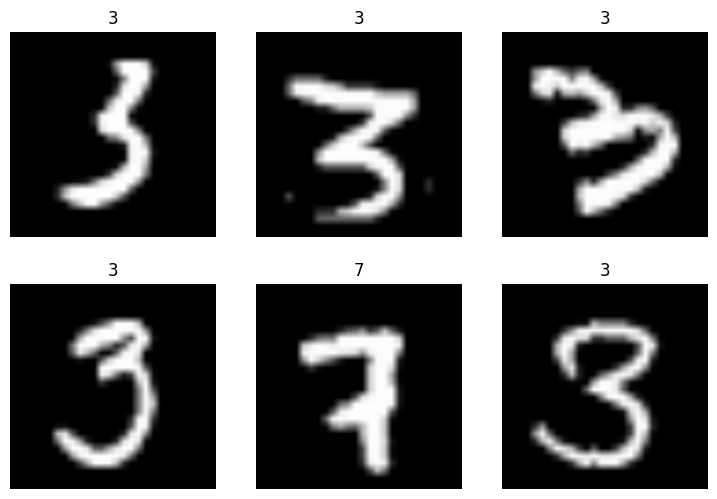

In [13]:
train_path = os.path.join(cn.DATA_MNIST_SMALL, cn.TRAINING)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(train_path)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
#learn = vision_learner(dls, models.efficientnet_v2_m, metrics=error_rate)
learn.fit(30)  # Number of epochs
# Output: epoch, training loss, validation loss, accuracy, time

In [7]:
??learn.fit

Signature:
learn.fit(
    n_epoch,
    lr=None,
    wd=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Docstring: Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.
Source:   
    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False, start_epoch=0):
        if start_epoch != 0:
            cbs = L(cbs) + SkipToEpoch(start_epoch)
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            self.opt.set_hypers(lr=self.lr if lr is None else lr)
            self.n_epoch = n_epoch
            self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
File:      ~/home/Technical/repos/keras/ker/lib/python3.9/site-packages/fastai/learner.py
Type:      method

## Model then curate

1. Create a small dataset (1000 images) with 3 digits.
2. Evaluate quality

# 